In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def load_data(path='mnist.h5'):
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), np.array(handle['labels'])
    
data, labels = load_data()

In [15]:
def preprocess_data(data, labels):
    return data.reshape(data.shape[0], -1), to_categorical(labels)

preprocessed_data, preprocessed_labels = preprocess_data(data, labels)

In [20]:
def partition(data, labels, train_fraction=0.8):
    samples = data.shape[0]
    cutoff = int(samples * train_fraction)
    
    return data[:cutoff], labels[:cutoff], data[cutoff:], labels[cutoff:]

train_data, train_labels, test_data, test_labels = partition(preprocessed_data, preprocessed_labels)
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((56000, 784), (56000, 10), (14000, 784), (14000, 10))

In [27]:
def build_model(data, classes):
    model = Sequential()
    
    model.add(Dense(512, activation='sigmoid', input_shape=data.shape[1:]))
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(preprocessed_data, classes=preprocessed_labels.shape[1])

In [28]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs):
        self.loss = []
        self.acc = []
        self.validation_loss = []
        self.validation_acc = []
        
    def on_batch_end(self, _, logs):
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'acc' in logs:
            self.acc.append(logs['acc'])
            
    def on_epoch_end(self, _, logs):
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])
        if 'val_acc' in logs:
            self.validation_acc.append(logs['val_acc'])

In [29]:
def train_model(model, train_data, train_labels, test_data, test_labels, epochs=50, batch_size=64):
    history = TrainingHistory()
    model.fit(
        train_data, train_labels, validation_data=(test_data, test_labels,),
        epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[history]
    )
    return history
    
history = train_model(model, train_data, train_labels, test_data, test_labels)

Train on 56000 samples, validate on 14000 samples
Epoch 1/50
56000/56000 [==============================] - 10s 178us/step - loss: 1.7132 - acc: 0.6377 - val_loss: 1.2045 - val_acc: 0.7900
Epoch 2/50
56000/56000 [==============================] - 10s 175us/step - loss: 0.9849 - acc: 0.8152 - val_loss: 0.7647 - val_acc: 0.8534
Epoch 3/50
56000/56000 [==============================] - 9s 164us/step - loss: 0.7105 - acc: 0.8459 - val_loss: 0.5921 - val_acc: 0.8724
Epoch 4/50
56000/56000 [==============================] - 10s 170us/step - loss: 0.5882 - acc: 0.8615 - val_loss: 0.5048 - val_acc: 0.8814
Epoch 5/50
56000/56000 [==============================] - 10s 172us/step - loss: 0.5203 - acc: 0.8705 - val_loss: 0.4519 - val_acc: 0.8905
Epoch 6/50
56000/56000 [==============================] - 10s 178us/step - loss: 0.4770 - acc: 0.8768 - val_loss: 0.4179 - val_acc: 0.8951
Epoch 7/50
56000/56000 [==============================] - 10s 175us/step - loss: 0.4471 - acc: 0.8814 - val_loss: 0.3

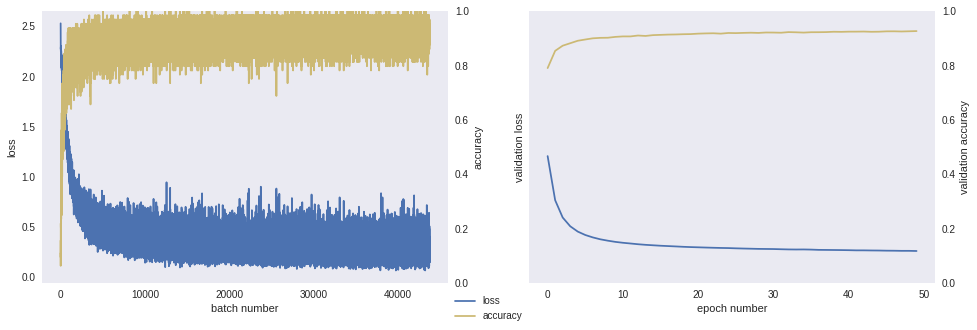

In [30]:
def plot_history(history):
    figure, (batch_axis, epoch_axis) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    # plot the training loss and accuracy
    batch_axis.set_xlabel('batch number')
    training_batches = np.arange(len(history.loss))
    
    batch_axis.grid(False)
    batch_axis.plot(training_batches, history.loss, color='C0', label='loss')
    batch_axis.set_ylabel('loss')
    
    batch_acc_axis = batch_axis.twinx()
    batch_acc_axis.grid(False)
    batch_acc_axis.set_ylabel('accuracy')
    batch_acc_axis.set_ylim(bottom=0.0)
    batch_acc_axis.plot(training_batches, history.acc, color='C4', label='accuracy')
    
    # plot the training loss and accuracy
    epoch_axis.set_xlabel('epoch number')
    validation_epochs = np.arange(len(history.validation_loss))
    
    epoch_axis.grid(False)
    epoch_axis.plot(validation_epochs, history.validation_loss, color='C0')
    epoch_axis.set_ylabel('validation loss')
    
    epoch_acc_axis = epoch_axis.twinx()
    epoch_acc_axis.grid(False)
    epoch_acc_axis.set_ylabel('validation accuracy')
    epoch_acc_axis.set_ylim(bottom=0.0)
    epoch_acc_axis.plot(validation_epochs, history.validation_acc, color='C4')
    
    # display a legend
    figure.legend(loc=8)
    plt.show()

plot_history(history)

In [32]:
def predict(model, test_data, batch_size=64):
    return model.predict(test_data, batch_size=64)

test_prediction = predict(model, test_data)
test_prediction.shape

((56000, 10), (14000, 10))

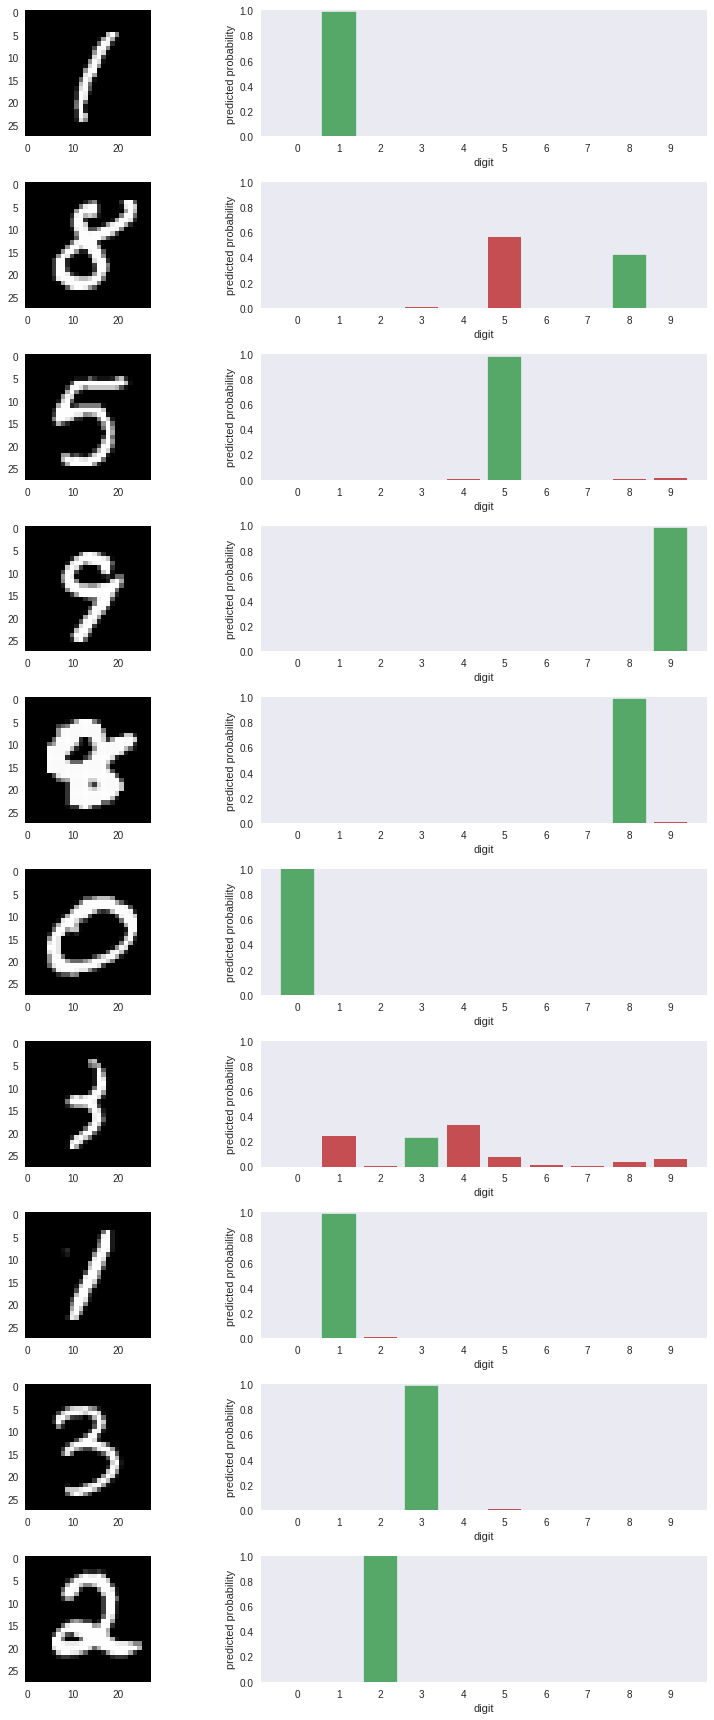

In [55]:
def visualize_prediction(data, labels, prediction, how_many=10):
    figure, axes = plt.subplots(how_many, 2, figsize=(12, 24))
    digits = np.arange(labels.shape[1])
    
    for i in range(how_many):
        left, right = axes[i]
        
        left.imshow(data[i].reshape(28, 28), cmap='gist_gray')
        left.grid(False)
        
        bars = right.bar(digits, prediction[i], color='C2')
        correct_label = np.argmax(labels[i])
        bars[correct_label].set_color('C1')
        right.grid(False)
        
        right.set_xlabel('digit')
        right.set_xticks(digits)
        
        right.set_ylim(0.0, 1.0)
        right.set_ylabel('predicted probability')
        
    plt.tight_layout()
    plt.show()
    
visualize_prediction(test_data, test_labels, test_prediction)

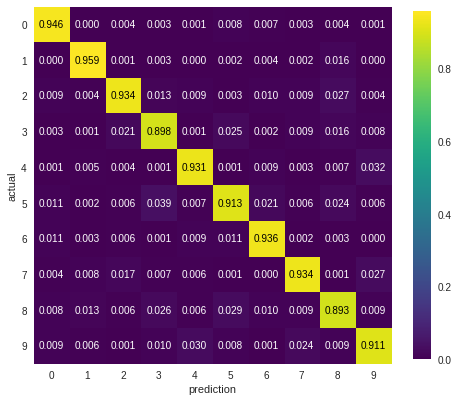

In [121]:
def show_confusion_matrix(labels, prediction):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    classes = labels.shape[1]
    buckets = np.arange(classes)
    confusion = np.histogram2d(np.argmax(labels, axis=1), np.argmax(prediction, axis=1), bins=classes)[0]
    confusion /= confusion.sum(axis=0)
    
    figure, axis = plt.subplots(1, figsize=(8, 8))
    axis.grid(False)
    image = axis.imshow(confusion, cmap='viridis')
    axis.set_xlabel('prediction')
    axis.set_xticks(buckets)
    axis.set_ylabel('actual')
    axis.set_yticks(buckets)
    figure.colorbar(image, shrink=0.8)
    
    for y in range(classes):
        for x in range(classes):
            value = confusion[y, x]
            color = 'white' if value <= 0.5 else 'black'
            plt.annotate('{:.3f}'.format(float(value)), xy=(x, y), color=color, ha='center', va='center')
            
    plt.show()

show_confusion_matrix(test_labels, test_prediction)